# Marketing econometrics
## Build a RFM segmentation
### MASTER 2 STATECO - TSE - 2020-2021



In [65]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [66]:
pd.set_option('display.max_columns', 100)

## 1. Load the data

Import the 6 csv tables in a Jupyter notebook with Python 3 and look at the first rows of each table.

In [67]:
mypath = "C:\\Users\\aurel\\Desktop\\TSE\\1 - Econometrics of Marketing\\Data"

In [68]:
CUSTOMER = pd.read_csv(mypath+"/CUSTOMER.csv")
CUSTOMER_ADDITIONAL = pd.read_csv(mypath+"/CUSTOMER_ADDITIONAL.csv")
PRODUCTS = pd.read_csv(mypath+"/PRODUCTS.csv")
RECEIPTS = pd.read_csv(mypath+"/RECEIPTS.csv")
REFERENTIAL = pd.read_csv(mypath+"/REFERENTIAL.csv")
STORE = pd.read_csv(mypath+"/STORE.csv")

## 2. Selection and merging of the data

### Exercise 1: Build the CUSTOMERS_INFO and the RECEIPTS_INFO tables containing all the information

#### Join the CUSTOMER’s dimensions (CUSTOMER and CUSTOMER_ADDITIONAL) in a table called CUSTOMER_INFO

- Drop ID_FOYER

In [69]:
CUSTOMER = CUSTOMER.drop(columns=['ID_FOYER'])

- Keep CODE_MAGASIN in CUSTOMER_ADDITIONAL and join to CUSTOMERS table

In [70]:
CUSTOMERS_INFO = CUSTOMER.merge(CUSTOMER_ADDITIONAL[['ID_INDIVIDU', 'CODE_MAGASIN']], on='ID_INDIVIDU', how='left')

- Rename CODE_MAGASIN in MANAGING_STORE

In [71]:
CUSTOMERS_INFO.rename(columns={'CODE_MAGASIN':'MANAGING_STORE'}, inplace=True)

#### Join the RECEIPTS’s dimensions (STORE, REFERENTIAL, PRODUCTS and RECEIPTS) in a table called RECEIPTS_INFO

In [72]:
RECEIPTS['EAN'] = RECEIPTS['EAN'].astype('object')

In [73]:
RECEIPTS_INFO = RECEIPTS.merge(REFERENTIAL, on='EAN', how='left')

- Keep only Ligne and Famille from PRODUCTS

In [74]:
RECEIPTS_INFO = RECEIPTS_INFO.merge(PRODUCTS[['MODELE', 'Ligne', 'Famille']], on='MODELE', how='left')

- Keep only REGIONS, CENTRE_VILLE, TYPE_MAGASIN and REGIONS_COMMERCIAL from STORE

In [75]:
RECEIPTS_INFO = RECEIPTS_INFO.merge(STORE[['CODE_BOUTIQUE', 'REGIONS', 'CENTRE_VILLE', 'TYPE_MAGASIN', 'REGIONS_COMMERCIAL']], 
                                    on='CODE_BOUTIQUE', how='left')

Finally we have 

- a CUSTOMERS_INFO table with 36157 rows and 16 columns, and 
- a RECEIPTS_INFO table with 332736 rows and 33 columns.

## 3. Understanding the data

One receipt seems to correspond to one ID_INDIVIDU x CODE_BOUTIQUE x DATE_ACHAT x NUM_TICKET.

### Exercise 2: Audit and analysis of the consistency of the following variables

From the 2 databases previously built, study the consistency of the following variables with relevant univariate distribution and cross repartitions

#### Features to analyze in RECEIPTS_INFO

In [76]:
list_var = ["REGIONS", "CENTRE_VILLE", "TYPE_MAGASIN", "REGIONS_COMMERCIAL", "MODELE", 
            "Ligne", "Famille", "EAN", "PRIX_AP_REMISE", "QUANTITE", "REMISE_VALEUR","REMISE"]

#### Identify potential inconsistencies and submit adequate management rules

We can remark several things:

- The counts are not equal to 332736 (the number of rows in RECEIPTS_INFO) for every columns, meaning that there are some **missing values**
- REGIONS and REGIONS_COMMERCIAL have the same number of modalities (2) with the same mode 'Province'. They seem to be **redundant -> to be check**
- There are 234 MODELE, 15 families and 3 lines
- The EAN is not at the good format, it should be a **'object' type**
- The price after discount is between 0 and 225€ -> **check the prices equal to 0**
- The quantity is between 1 and 10. OK
- The discount value is 0 most of the time (>75%) but can reach 8520€ -> **check for outliers**

In [77]:
RECEIPTS_INFO["EAN"] = RECEIPTS_INFO["EAN"].astype(str)

#### Features to analyze in CUSTOMERS_INFO

In [78]:
YEAR_BIRTH = CUSTOMERS_INFO.loc[CUSTOMERS_INFO.DATE_NAISS_A.notnull(),["DATE_NAISS_A"]]
AGE = 2016-YEAR_BIRTH

In [79]:
YEAR_CREAT = CUSTOMERS_INFO.DATE_CREATION_CARTE.str.slice(6, 10)
SENIORITY = 2016 - YEAR_CREAT.astype(float)

- Identify potential inconsistencies and propose a way to correct them

We can consider that the seniorities of 27 years are outliers.

## 4. Data preparation: cleaning and creation of indicators

#### Exercise 3: Data cleaning

Define and apply the rules needed to clean the data (missing values, outliers…)

- Dates have to be at a date format
- FAVO and FAVORI are gifts so the corresponding PRICE = 0
- PLV means "promotion en lieu de vente" and should be distinguished from gifts
- The final price is PRIX_AP_REMISE x QUANTITE
- Group Centre Co and Centre commercial, and fill NAN by "" in CENTRE_VILLE
- Compute the age and replace <15 and >90 years old by null (done in exercise 4)
- Seniority > 10 replaced by null (done in exercise 4)

##### Data preparation of RECEIPTS_INFO

In [80]:
RECEIPTS_INFO_OK = RECEIPTS_INFO.copy()

In [81]:
RECEIPTS_INFO_OK["DATE_ACHAT"] = RECEIPTS_INFO_OK["DATE_ACHAT"].apply(lambda x: x[1:-1])

In [82]:
RECEIPTS_INFO_OK["DATE_ACHAT"] = pd.to_datetime(RECEIPTS_INFO_OK["DATE_ACHAT"])

In [83]:
RECEIPTS_INFO_OK["TOP_GIFT"] = np.where(RECEIPTS_INFO_OK['MODELE'].isin(["FAVO", "FAVORI"]), 1, 0)
RECEIPTS_INFO_OK["TOP_PLV"] = np.where(RECEIPTS_INFO_OK['MODELE'].isin(["PLV"]), 1, 0)

In [84]:
RECEIPTS_INFO_OK["PRICE"] = np.where(RECEIPTS_INFO_OK['MODELE'].isin(["FAVO", "FAVORI"]), 0, RECEIPTS_INFO_OK['PRIX_AP_REMISE']*RECEIPTS_INFO_OK['QUANTITE'])

In [85]:
RECEIPTS_INFO_OK["CENTRE_VILLE"] = np.where(RECEIPTS_INFO_OK['CENTRE_VILLE'].isin(["Centre Commercial", "Centre Co"]), "Shopping center", 
                                          np.where(RECEIPTS_INFO_OK['CENTRE_VILLE'] == 'Centre ville', 'City center', "NA"))

##### Data preparation of CUSTOMERS_INFO

In [86]:
CUSTOMERS_INFO_OK = CUSTOMERS_INFO.copy()

#### Exercise 4: Indicators calculation 

Scope: on the last 12 months available

In [87]:
min_date_RFM = '2015-12-01 00:00:00'
max_date_RFM = '2016-11-30 00:00:00'

In [88]:
RECEIPTS_INFO_RFM = RECEIPTS_INFO_OK[(RECEIPTS_INFO_OK.DATE_ACHAT >= min_date_RFM) & (RECEIPTS_INFO_OK.DATE_ACHAT <= max_date_RFM)]

##### Compute MONETARY VALUE per visit and the average price:

In [89]:
VISIT_VALUE = RECEIPTS_INFO_RFM[
    ~RECEIPTS_INFO_RFM.MODELE.isin(["FAVO","FAVORI","PLV"])].groupby(
    ["DATE_ACHAT", "CODE_BOUTIQUE", "ID_INDIVIDU", "NUM_TICKET"]).aggregate(
    {'PRICE': 'sum', 'QUANTITE': 'sum'}).reset_index()

In [90]:
VISIT_VALUE.columns = ['DATE_ACHAT', 'CODE_BOUTIQUE', 
                               'ID_INDIVIDU', 'NUM_TICKET', 
                               'VISIT_VALUE', 'NB_PRODUCTS']

In [91]:
VISIT_VALUE["AVG_PRICE"] = VISIT_VALUE["VISIT_VALUE"]/VISIT_VALUE["NB_PRODUCTS"]

##### Calculate FREQUENCY per individual (from the precedent table per visit):

In [92]:
agg_dict = {"DATE_ACHAT": ["count"],
            "VISIT_VALUE": ["mean", 'sum'],
            'NB_PRODUCTS': ['mean']
           }

FREQUENCY = VISIT_VALUE.groupby('ID_INDIVIDU').aggregate(
    agg_dict, drop_index=True).reset_index()

In [93]:
FREQUENCY.columns = ['ID_INDIVIDU','NB_VISITS','AVG_VISIT_VALUE', 'CUMUL_VALUE','AVG_NB_PRODUCTS_VISIT']

##### Calculate RECENCY per individual:

In [94]:
RECENCY = VISIT_VALUE.groupby('ID_INDIVIDU').aggregate(
    {'DATE_ACHAT': 'max'}).reset_index()

In [95]:
RECENCY["DATE_ACHAT"] = pd.to_datetime(RECENCY["DATE_ACHAT"])

In [96]:
max_date_RFM = pd.to_datetime(max_date_RFM)

In [97]:
RECENCY["RECENCY"] = (max_date_RFM - RECENCY["DATE_ACHAT"])/np.timedelta64(1, 'D')

##### Diversification in terms of stores, lines and families

In [98]:
DIVERS_STORE = RECEIPTS_INFO_RFM[(RECEIPTS_INFO_RFM.MODELE != "PLV") 
                          & (RECEIPTS_INFO_RFM.CODE_BOUTIQUE.notnull())].groupby('ID_INDIVIDU')["CODE_BOUTIQUE"].nunique().reset_index()
DIVERS_STORE.columns = ['ID_INDIVIDU', 'NB_STORES']

In [99]:
DIVERS_LINE = RECEIPTS_INFO_RFM[(~RECEIPTS_INFO_RFM.MODELE.isin(["FAVO","FAVORI","PLV"])) 
                          & (RECEIPTS_INFO_RFM.Ligne.notnull())].groupby('ID_INDIVIDU')["Ligne"].nunique().reset_index()
DIVERS_LINE.columns = ['ID_INDIVIDU', 'NB_LINES']

In [100]:
DIVERS_FAM = RECEIPTS_INFO_RFM[(~RECEIPTS_INFO_RFM.MODELE.isin(["FAVO","FAVORI","PLV"])) 
                          & (RECEIPTS_INFO_RFM.Famille.notnull())].groupby('ID_INDIVIDU')["Famille"].nunique().reset_index()
DIVERS_FAM.columns = ['ID_INDIVIDU', 'NB_FAMILIES']

##### Number of gifts

In [101]:
NB_GIFTS = RECEIPTS_INFO_RFM[(RECEIPTS_INFO_RFM.MODELE.isin(["FAVO","FAVORI"])) 
                          | (RECEIPTS_INFO_RFM.PRICE==0)].groupby('ID_INDIVIDU')["DATE_ACHAT"].count().reset_index()
NB_GIFTS.columns = ['ID_INDIVIDU', 'NB_GIFTS']

##### Share of visits in the managing store

In [102]:
MANAGING_STORE = VISIT_VALUE[["ID_INDIVIDU","CODE_BOUTIQUE"]].merge(CUSTOMERS_INFO_OK[["ID_INDIVIDU","MANAGING_STORE"]], 
                                                                    on="ID_INDIVIDU")

In [103]:
MANAGING_STORE["TOP_MANAGING_STORE"] = np.where(MANAGING_STORE["CODE_BOUTIQUE"]
                                                ==MANAGING_STORE["MANAGING_STORE"], 1, 0)

In [104]:
SHARE_MANAGING_STORE = MANAGING_STORE.groupby('ID_INDIVIDU')["TOP_MANAGING_STORE"].mean().reset_index()
SHARE_MANAGING_STORE.columns = ['ID_INDIVIDU', 'SHARE_MANAGING_STORE']

##### Age and seniority

In [105]:
CUSTOMERS_INFO_OK["BIRTH_YEAR"] = CUSTOMERS_INFO_OK["DATE_NAISS_A"].fillna(0).astype(int)
CUSTOMERS_INFO_OK["BIRTH_MONTH"] = CUSTOMERS_INFO_OK["DATE_NAISS_M"].fillna(0).astype(int)
CUSTOMERS_INFO_OK["BIRTH_DAY"] = CUSTOMERS_INFO_OK["DATE_NAISS_J"].fillna(0).astype(int)

In [106]:
CUSTOMERS_INFO_OK["BIRTH_DATE"] = pd.to_datetime(dict(year=CUSTOMERS_INFO_OK.BIRTH_YEAR, 
                                                      month=CUSTOMERS_INFO_OK.BIRTH_MONTH, 
                                                      day=CUSTOMERS_INFO_OK.BIRTH_DAY), 
                                                 errors='coerce')

In [107]:
CUSTOMERS_INFO_OK["DATE_CREATION_CARTE"] = pd.to_datetime(CUSTOMERS_INFO_OK["DATE_CREATION_CARTE"])

In [108]:
CUSTOMERS_INFO_OK["AGE"] = round(((max_date_RFM - CUSTOMERS_INFO_OK["BIRTH_DATE"])/np.timedelta64(1, 'Y')),0)

In [109]:
#Exercise 3:
CUSTOMERS_INFO_OK["AGE"] = np.where((CUSTOMERS_INFO_OK["AGE"]<15) | (CUSTOMERS_INFO_OK["AGE"]>90), np.nan, CUSTOMERS_INFO_OK["AGE"]) 

In [110]:
#Seniority in months
CUSTOMERS_INFO_OK["SENIORITY"] = (max_date_RFM - CUSTOMERS_INFO_OK["DATE_CREATION_CARTE"])/np.timedelta64(1, 'M')

In [111]:
#Exercise 3: if greater than 10 years -> NaN
CUSTOMERS_INFO_OK["SENIORITY"] = np.where((CUSTOMERS_INFO_OK["SENIORITY"]>120), np.nan, CUSTOMERS_INFO_OK["SENIORITY"]) 
#another way to change the values according to a condition:
CUSTOMERS_INFO_OK.loc[CUSTOMERS_INFO_OK["SENIORITY"]<0,["SENIORITY"]] = 0

##### Gather all features in a MASTER table (at the individual level):

In [112]:
MASTER = CUSTOMERS_INFO_OK[['ID_INDIVIDU', 'CIVILITE', 
                            'SEXE', 'PROFESSION', 'CATEGORIE_PROF', 
                            'DATE_CREATION_CARTE','MANAGING_STORE',
                            'AGE', 'SENIORITY']].merge(SHARE_MANAGING_STORE,
                                                       on='ID_INDIVIDU',
                                                       how='left')

In [113]:
MASTER = MASTER.merge(NB_GIFTS, on='ID_INDIVIDU', how='left')

In [114]:
MASTER = MASTER.merge(DIVERS_STORE, on='ID_INDIVIDU', how='left')
MASTER = MASTER.merge(DIVERS_LINE, on='ID_INDIVIDU', how='left')
MASTER = MASTER.merge(DIVERS_FAM, on='ID_INDIVIDU', how='left')

In [115]:
MASTER = MASTER.merge(RECENCY, on='ID_INDIVIDU', how='left')
MASTER = MASTER.merge(FREQUENCY, on='ID_INDIVIDU', how='left')

For the RFM segmentation we exclude inactive customers on the year of study.

In [116]:
MASTER_RFM = MASTER[MASTER.RECENCY.notnull()]

## 5. Creation of the "RFM" segmentation

In [117]:
# Remove customers that came only for gifts
MASTER_RFM = MASTER_RFM.loc[(MASTER_RFM.CUMUL_VALUE > 0.0),]

In [118]:
#New customer if seniority <= 1 year
MASTER_RFM["TOP_NEW"] = np.where((MASTER_RFM.SENIORITY <= 12), 1, 0)

## Determine thresholds in order to split them in low/medium/high groups

In [119]:
MASTER_RFM["TOP_INACTIVE"] = np.where((MASTER_RFM.NB_VISITS == 0), 1, 0)

So we can propose the following thresholds:

MONETARY VALUE:
- low if less than 100€
- medium if between 100€ and 250€
- high if more than 250€

FREQUENCY:
- Inactive if 0 visit on the periode
- low if 1 visit on the period
- medium if 2 visits on the period
- high if 3 visits or more on the period

RECENCY: 
- low if last purchase more than 7 months ago (210 days)
- medium if last purchase between 4 and 7 months ago
- high if last purchase less than 4 months ago (120 days)

In [120]:
min_recency = 120
max_recency = 210
min_frequency = 2
max_frequency = 3
min_money = 100
max_money = 250

In [121]:
MASTER_RFM["RECENCY_level"] = np.where(MASTER_RFM.TOP_INACTIVE == 1, 'Inactive',
                                       np.where(MASTER_RFM.TOP_NEW == 1, 'New',
                                                np.where(MASTER_RFM.RECENCY > max_recency, 'Low',
                                                     np.where(MASTER_RFM.RECENCY <= min_recency, 'High',
                                                              'Medium'))))

In [122]:
MASTER_RFM["FREQUENCY_level"] = np.where(MASTER_RFM.TOP_INACTIVE == 1, 'Inactive',
                                         np.where(MASTER_RFM.TOP_NEW == 1, 'New',
                                                  np.where(MASTER_RFM.NB_VISITS < min_frequency, 'Low',
                                                           np.where((MASTER_RFM.NB_VISITS >= max_frequency)&(MASTER_RFM.NB_VISITS > 0), 'High',
                                                                    'Medium'))))

In [123]:
MASTER_RFM["MONEY_level"] = np.where(MASTER_RFM.TOP_INACTIVE == 1, 'Inactive',
                                     np.where(MASTER_RFM.TOP_NEW == 1, 'New',
                                              np.where(MASTER_RFM.CUMUL_VALUE < min_money, 'Low',
                                                       np.where(MASTER_RFM.CUMUL_VALUE >= max_money, 'High',
                                                                'Medium'))))

Check that the Low/Medium/High classes are quite well balanced. If not, try to change the thresholds.

In [124]:
cond_LowFM = ((MASTER_RFM.FREQUENCY_level=='Low') 
              & ((MASTER_RFM.MONEY_level=='Low') 
                 | (MASTER_RFM.MONEY_level=='Medium'))) | ((MASTER_RFM.FREQUENCY_level=='Medium') 
                                                       & (MASTER_RFM.MONEY_level=='Low'))
cond_MediumFM = ((MASTER_RFM.FREQUENCY_level=='Low') 
              & ((MASTER_RFM.MONEY_level=='Low') 
                 | (MASTER_RFM.MONEY_level=='Medium'))) | ((MASTER_RFM.FREQUENCY_level=='Medium') 
                                                       & (MASTER_RFM.MONEY_level=='Low'))
cond_HighFM = ((MASTER_RFM.FREQUENCY_level=='High') 
               & ((MASTER_RFM.MONEY_level=='High') 
                  | (MASTER_RFM.MONEY_level=='Medium'))) | ((MASTER_RFM.FREQUENCY_level=='Medium') 
                                                        & (MASTER_RFM.MONEY_level=='High'))

In [125]:
MASTER_RFM["FM_SEG"] = np.where(MASTER_RFM.TOP_INACTIVE, 'Inactive',
                                np.where(MASTER_RFM.TOP_NEW, 'New',
                                         np.where(cond_LowFM, 'Low',
                                                  np.where(cond_HighFM, 'High',
                                                           'Medium'))))

In [126]:

cond_Top = ((MASTER_RFM.RECENCY_level=='High') 
            & ((MASTER_RFM.FM_SEG=='High') | (MASTER_RFM.FM_SEG=='Medium')))
cond_Good = ((MASTER_RFM.RECENCY_level=='Medium') 
             & ((MASTER_RFM.FM_SEG=='High') | (MASTER_RFM.FM_SEG=='Medium')))
cond_Decel = ((MASTER_RFM.RECENCY_level=='Low') 
              & ((MASTER_RFM.FM_SEG=='High') | (MASTER_RFM.FM_SEG=='Medium')))
cond_Small = ((MASTER_RFM.FM_SEG=='Low') 
              & ((MASTER_RFM.RECENCY_level=='High') | (MASTER_RFM.RECENCY_level=='Medium')))
cond_Weak = ((MASTER_RFM.FM_SEG=='Low') & (MASTER_RFM.RECENCY_level=='Low'))


In [127]:
MASTER_RFM["RFM_SEG"] = np.where(cond_Top, 'Top',
                                 np.where(cond_Good, 'Good',
                                          np.where(cond_Decel, 'Decel',
                                                   np.where(cond_Small, 'Small',
                                                            np.where(cond_Weak, 'Weak',
                                                                     MASTER_RFM.FM_SEG)))))

In [129]:
MASTER_RFM.RFM_SEG.value_counts()

New      3369
Weak     1694
Top      1683
Good     1655
Small    1601
Decel     699
Name: RFM_SEG, dtype: int64

## 6. Main insights

What is a weak customer ? 
* Low recency level
* Frequenly level and money level are low/medium 


Our job is to study the weak customer segment. For that, we need to compare it to the other segments, especially using the program sensitivity, eclecticism (number of lines) and diversification
(number of different families) criteria.

First, we create a sample for each segment:

In [130]:
Weak = MASTER_RFM[MASTER_RFM.RFM_SEG=="Weak"]
Top = MASTER_RFM[MASTER_RFM.RFM_SEG=="Top"] 
Small = MASTER_RFM[MASTER_RFM.RFM_SEG=="Small"] 
New = MASTER_RFM[MASTER_RFM.RFM_SEG=="New"] 
Good = MASTER_RFM[MASTER_RFM.RFM_SEG=="Good"] 
Decel = MASTER_RFM[MASTER_RFM.RFM_SEG=="Decel"] 

**Distribution of the segmentation**

In [131]:
hohoho = MASTER_RFM.RFM_SEG.value_counts()/MASTER_RFM.ID_INDIVIDU.count()*100
vector= [hohoho[2],hohoho[3],hohoho[4],hohoho[1],hohoho[5],hohoho[0]]

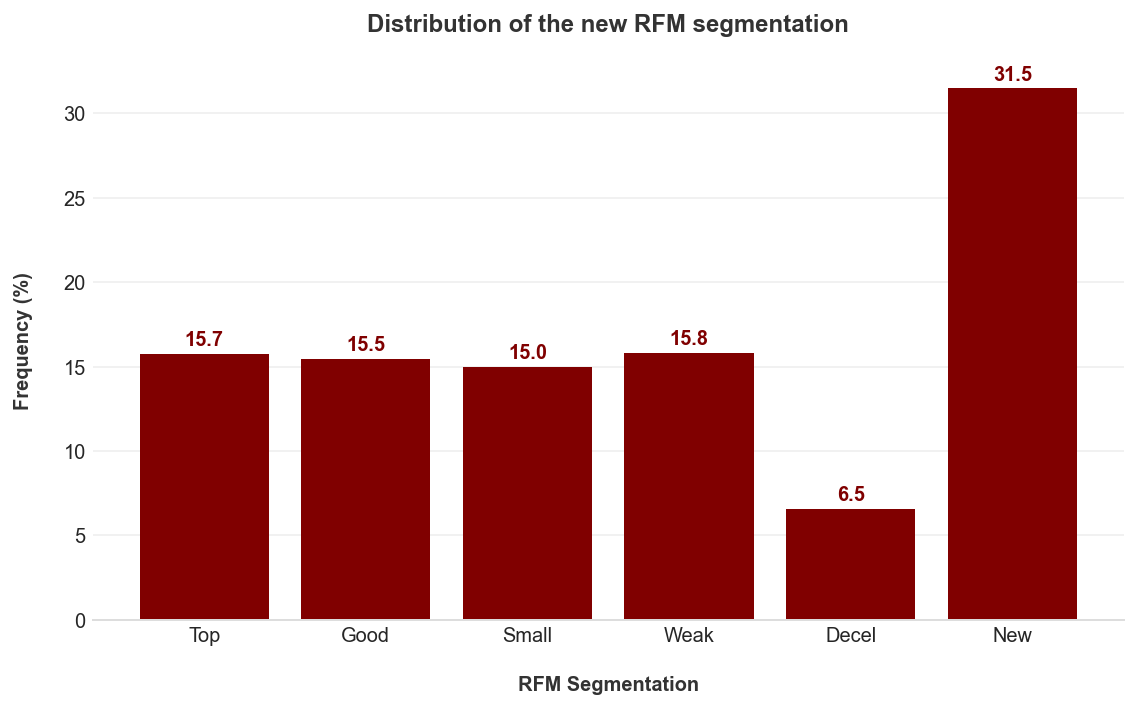

In [132]:
plt.style.use('seaborn-whitegrid') 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina', quality=100)

plt.rcParams['figure.figsize'] = (8, 5)

fig, ax = plt.subplots()

bars=ax.bar(["Top","Good","Small","Weak","Decel","New"],vector,color="maroon")


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

bar_color = bars[0].get_facecolor()
for bar in bars:
  ax.text(
      bar.get_x() + bar.get_width() / 2,
      bar.get_height() + 0.5,
      round(bar.get_height(), 1),
      horizontalalignment='center',
      color=bar_color,
      weight='bold'
  )

ax.set_xlabel('RFM Segmentation', labelpad=15, color='#333333',
             weight='bold')
ax.set_ylabel('Frequency (%)', labelpad=15, color='#333333',
             weight='bold')
ax.set_title('Distribution of the new RFM segmentation', pad=15, color='#333333',
             weight='bold')


fig.tight_layout()

fig.savefig('freqRFM.png')

**Program_sensitivity by RFM segments**

*Graph for reach of the program: % of ind that received at least one gift*

In [133]:
Pgr_sensitivity = MASTER_RFM[["RFM_SEG","NB_GIFTS",'ID_INDIVIDU']].groupby('RFM_SEG').count()
Pgr_sensitivity["frequency_gift"] = Pgr_sensitivity.NB_GIFTS/Pgr_sensitivity.ID_INDIVIDU*100

In [134]:
Pgr_sensitivity_sorted=Pgr_sensitivity
Pgr_sensitivity_sorted.iloc[0]=Pgr_sensitivity_sorted.iloc[4]
Pgr_sensitivity_sorted.iloc[1]=Pgr_sensitivity_sorted.iloc[1]
Pgr_sensitivity_sorted.iloc[2]=Pgr_sensitivity_sorted.iloc[3]
Pgr_sensitivity_sorted.iloc[3]=Pgr_sensitivity_sorted.iloc[5]
Pgr_sensitivity_sorted.iloc[4]=Pgr_sensitivity_sorted.iloc[0]
Pgr_sensitivity_sorted.iloc[5]=Pgr_sensitivity_sorted.iloc[3]

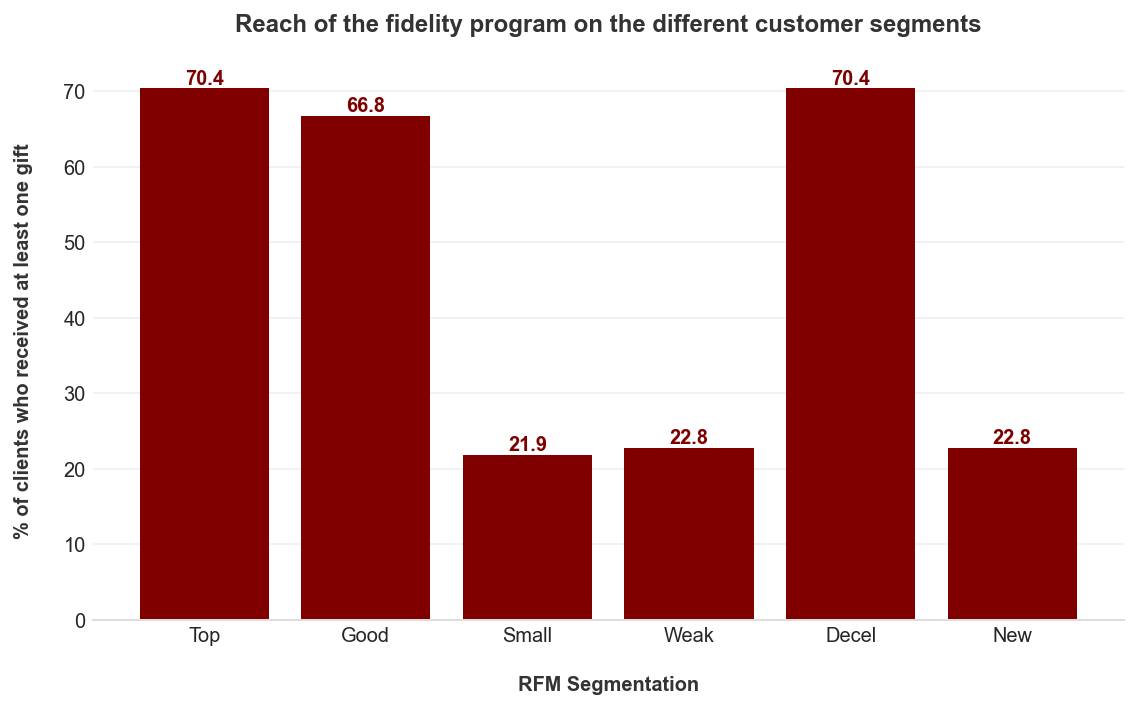

In [135]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina', quality=100)

plt.rcParams['figure.figsize'] = (8, 5)

fig, ax = plt.subplots()

bars=ax.bar(["Top","Good","Small","Weak","Decel","New"],Pgr_sensitivity["frequency_gift"],color="maroon")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

bar_color = bars[0].get_facecolor()
for bar in bars:
  ax.text(
      bar.get_x() + bar.get_width() / 2,
      bar.get_height() + 0.5,
      round(bar.get_height(), 1),
      horizontalalignment='center',
      color=bar_color,
      weight='bold'
  )

ax.set_xlabel('RFM Segmentation', labelpad=15, color='#333333',
             weight='bold')
ax.set_ylabel('% of clients who received at least one gift', labelpad=15, color='#333333',
             weight='bold')
ax.set_title('Reach of the fidelity program on the different customer segments', pad=15, color='#333333',
             weight='bold')


fig.tight_layout()

fig.savefig('freqgift.png')

*Graph for NB gifts VS NB of visits*

**TO DO**: change the legend: very easy on Excel with the heatmap option. Also, we need to do a few more graphs for the different segments (maybe 2-3 segments?)

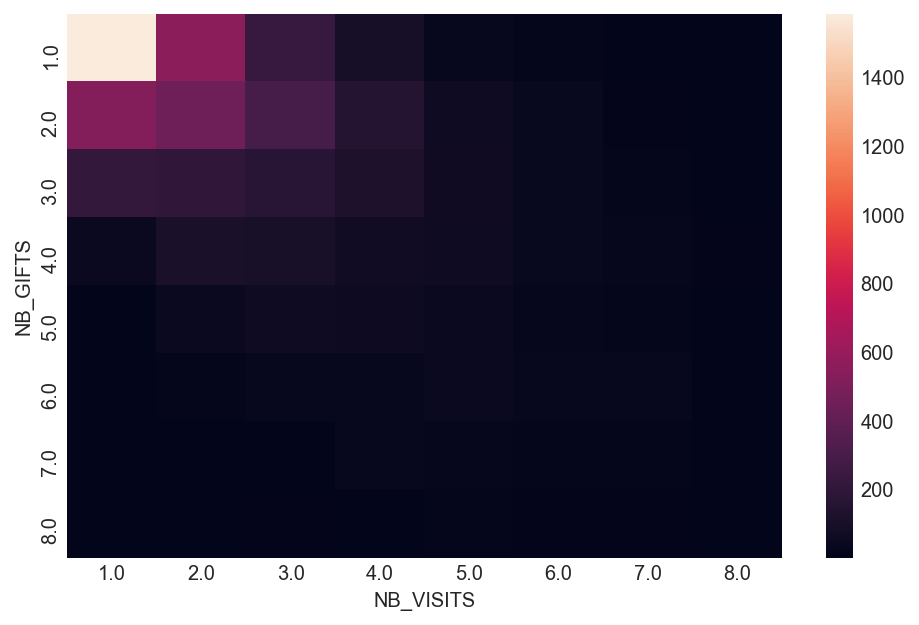

In [136]:
table = pd.crosstab(MASTER_RFM.NB_GIFTS, MASTER_RFM.NB_VISITS)
rows=table.iloc[0:8]
final=rows.loc[:,0:8]
sns.heatmap(final)

*Graph for NB gifts VS Cumulative total value*

**TO DO**: plot this graph with different color for each segment (also easy to do on EXCEL if hard here)
Maybe put the cumul value in log ? theres the majority between 0 and 1000 so maybe the graph would look better

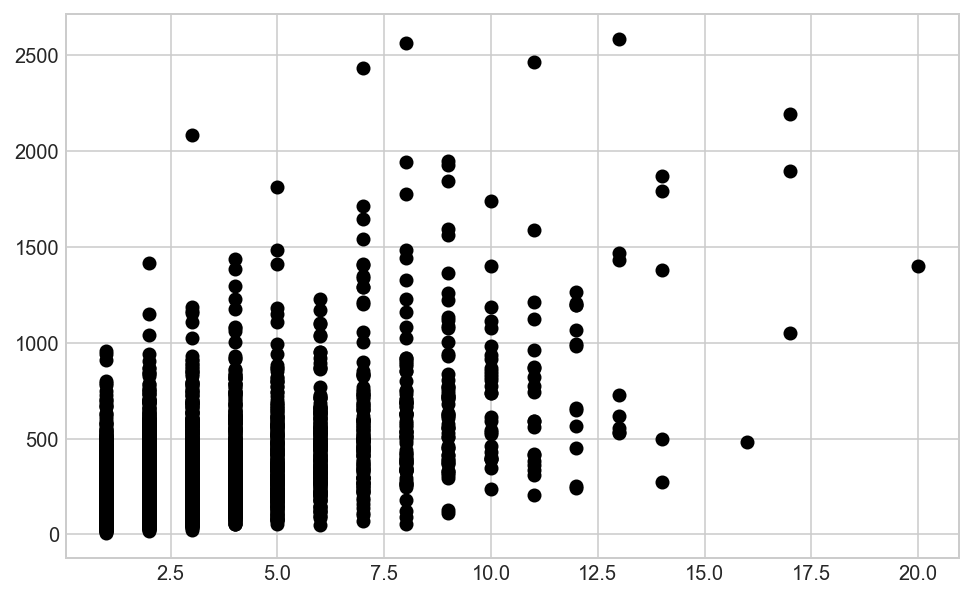

In [137]:
plt.plot(MASTER_RFM.NB_GIFTS, MASTER_RFM.CUMUL_VALUE, 'o', color='black');

**Number of LINES - RFM**

In [138]:
ohoho1 = pd.crosstab(MASTER_RFM["NB_LINES"],MASTER_RFM["RFM_SEG"],normalize="columns")*100
ohoho1=ohoho1.transpose()
ohoho1

NB_LINES,1.0,2.0,3.0
RFM_SEG,,,
Decel,37.052933,50.786838,12.160229
Good,26.948640,49.365559,23.685801
New,56.177434,35.873772,7.948794
Small,80.879541,18.483110,0.637349
Top,26.516052,45.422117,28.061831
Weak,82.971014,16.243961,0.785024


In [139]:
ohoho1.iloc[0] = ohoho1.iloc[4]
ohoho1.iloc[1] = ohoho1.iloc[1]
ohoho1.iloc[2] = ohoho1.iloc[3]
ohoho1.iloc[3] = ohoho1.iloc[5]
ohoho1.iloc[4] = ohoho1.iloc[0]
ohoho1.iloc[5] = ohoho1.iloc[2]
ohoho1 = ohoho1.rename(columns={1:'Corsetterie',2:'Bain',3:'Homewear'}, index={'Decel': 'Top','New':"Small",
                                                                                      'Small':'Weak','Top':'Decel',
                                                                                      'Weak':'New'})
ohoho1

NB_LINES,Corsetterie,Bain,Homewear
RFM_SEG,,,
Top,26.516052,45.422117,28.061831
Good,26.948640,49.365559,23.685801
Small,80.879541,18.483110,0.637349
Weak,82.971014,16.243961,0.785024
Decel,26.516052,45.422117,28.061831
New,80.879541,18.483110,0.637349


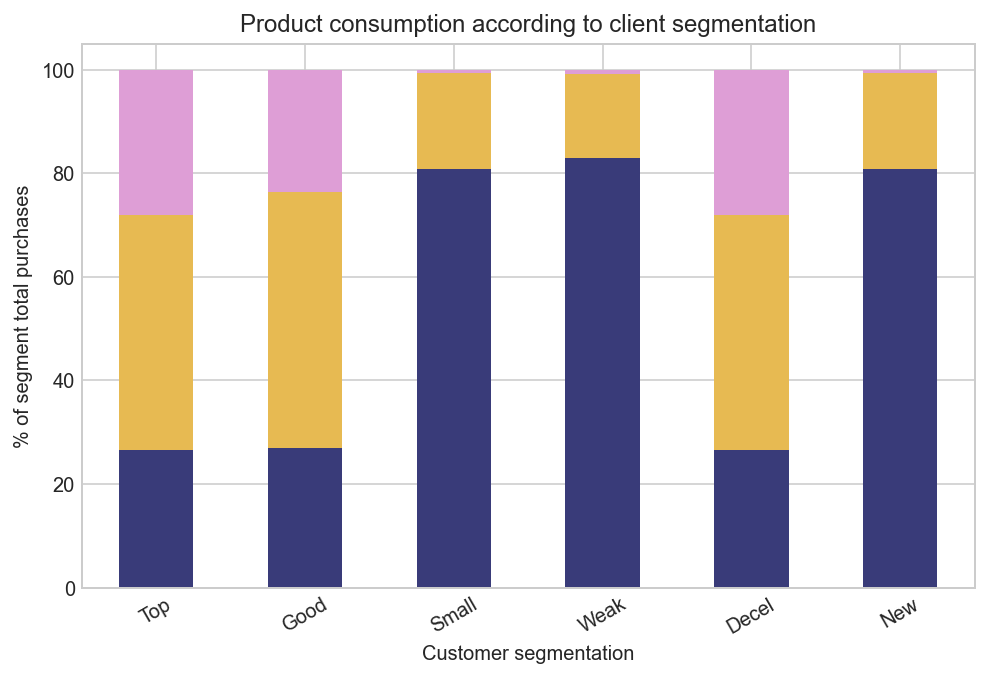

In [140]:
plt.style.use('seaborn-whitegrid') 
ohoho1.plot.bar(stacked=True,legend=False,colormap='tab20b')
plt.title("Product consumption according to client segmentation")
plt.xlabel("Customer segmentation")
plt.ylabel("% of segment total purchases")
plt.xticks(rotation=30, horizontalalignment="center")

plt.savefig('nber_line.png')


**Diversity RFM - looking at number of families**

In [141]:
nb_Fam_segment = pd.crosstab(MASTER_RFM["NB_FAMILIES"],MASTER_RFM["RFM_SEG"])

In [142]:
weak = MASTER_RFM.NB_FAMILIES[MASTER_RFM.RFM_SEG=='Weak']
top = MASTER_RFM.NB_FAMILIES[MASTER_RFM.RFM_SEG=='Top']
new = MASTER_RFM.NB_FAMILIES[MASTER_RFM.RFM_SEG=='New']
small = MASTER_RFM.NB_FAMILIES[MASTER_RFM.RFM_SEG=='Small']
decel = MASTER_RFM.NB_FAMILIES[MASTER_RFM.RFM_SEG=='Decel']
good = MASTER_RFM.NB_FAMILIES[MASTER_RFM.RFM_SEG=='Good']
new=new.to_frame()
top=top.to_frame()
small=small.to_frame()
decel=decel.to_frame()
good=good.to_frame()
weak=weak.to_frame()

Then we export the 6 tables to Excel to make the bowplots

**RFM segmentation: a closer look at Weak customers**

In [143]:
MASTER_RFM_noweak= MASTER_RFM[MASTER_RFM.RFM_SEG!="Weak"]

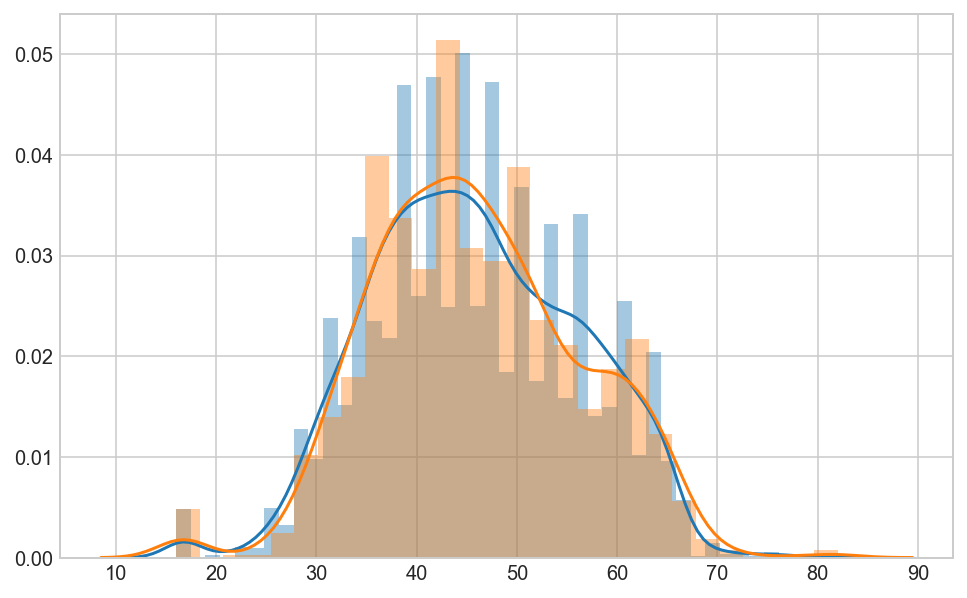

In [144]:
sns.distplot(MASTER_RFM_noweak.loc[MASTER_RFM_noweak.AGE.notnull(), ["AGE"]])
sns.distplot(Weak.loc[Weak.AGE.notnull(), ["AGE"]])
plt.show()

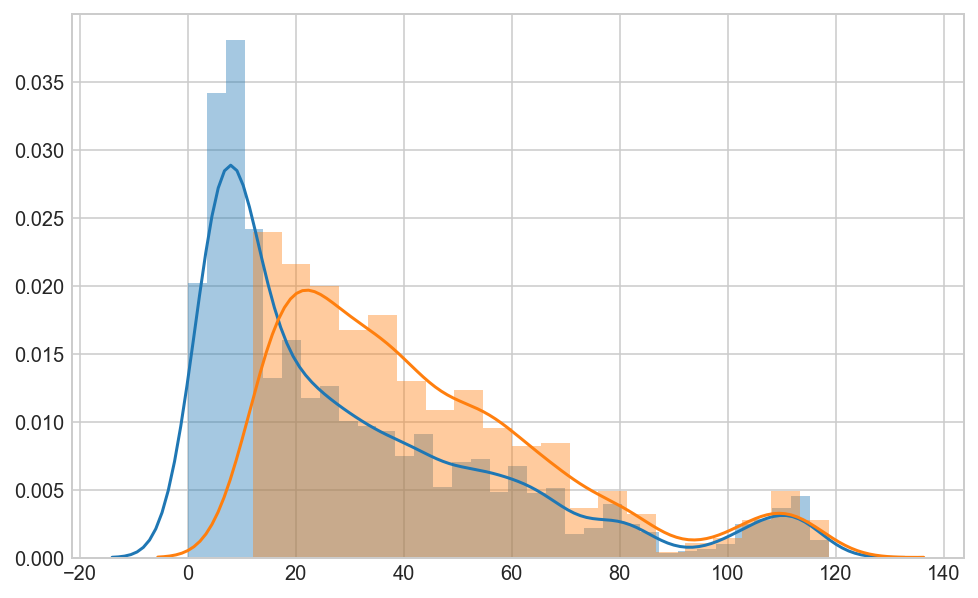

In [145]:
sns.distplot(MASTER_RFM_noweak.loc[MASTER_RFM_noweak.SENIORITY.notnull(), ["SENIORITY"]])
sns.distplot(Weak.loc[Weak.SENIORITY.notnull(), ["SENIORITY"]])
plt.show()

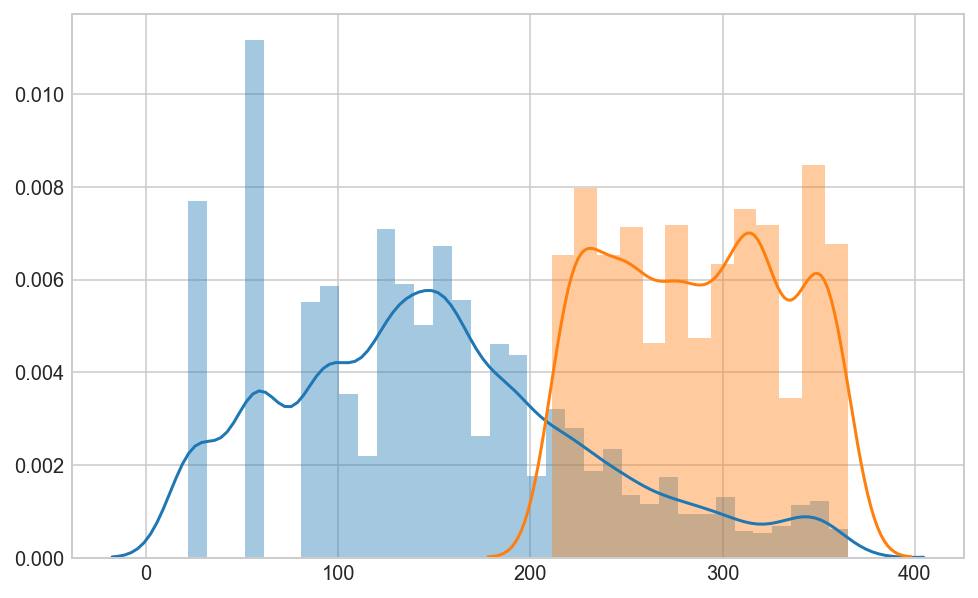

In [146]:
sns.distplot(MASTER_RFM_noweak.loc[MASTER_RFM_noweak.RECENCY.notnull(), ["RECENCY"]])
sns.distplot(Weak.loc[Weak.RECENCY.notnull(), ["RECENCY"]])
plt.show()

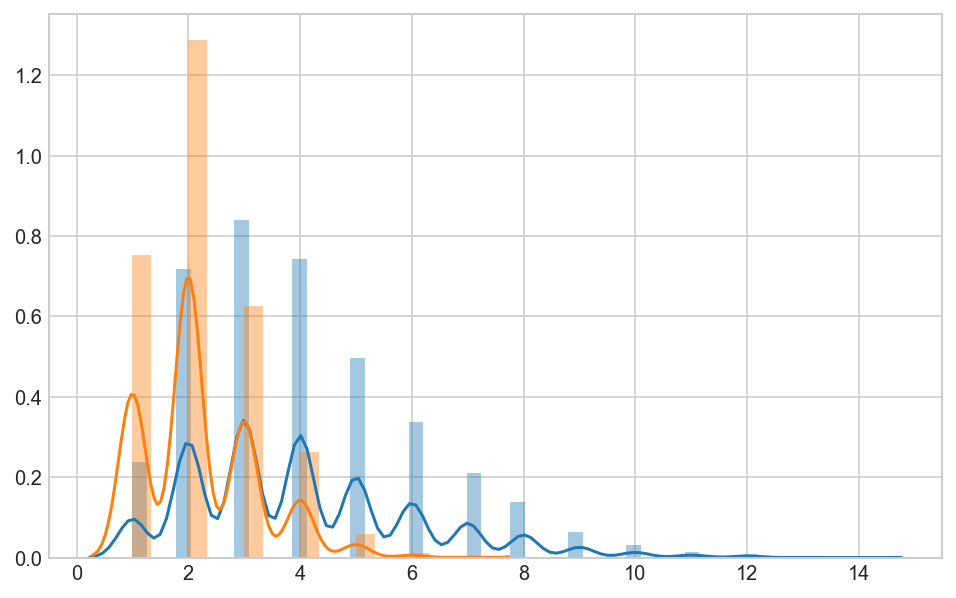

In [147]:
sns.distplot(MASTER_RFM_noweak.loc[MASTER_RFM_noweak.NB_FAMILIES.notnull(), ["NB_FAMILIES"]])
sns.distplot(Weak.loc[Weak.NB_FAMILIES.notnull(), ["NB_FAMILIES"]])
plt.show()

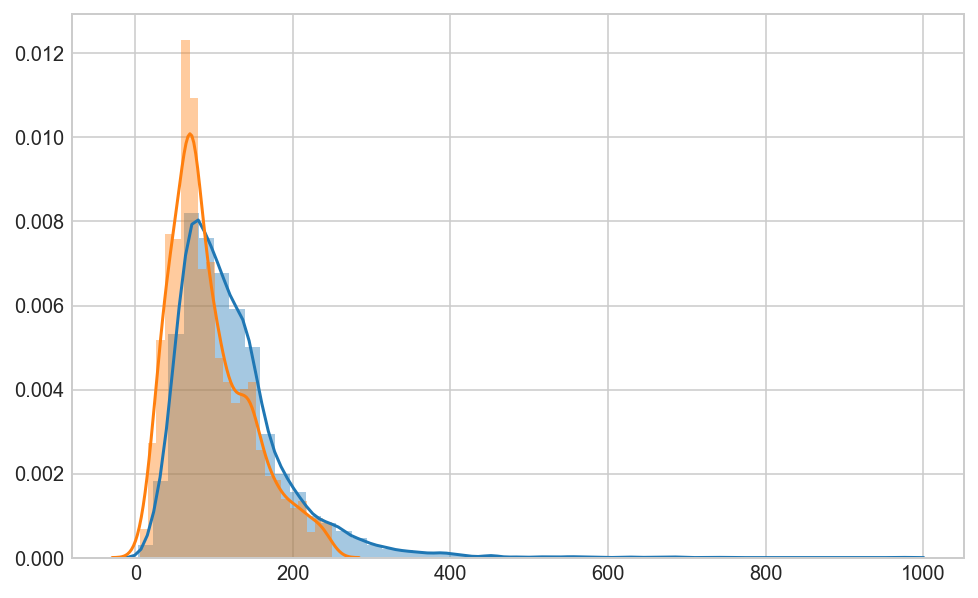

In [148]:
sns.distplot(MASTER_RFM_noweak.loc[MASTER_RFM_noweak.AVG_VISIT_VALUE.notnull(), ["AVG_VISIT_VALUE"]])
sns.distplot(Weak.loc[Weak.AVG_VISIT_VALUE.notnull(), ["AVG_VISIT_VALUE"]])
plt.show()

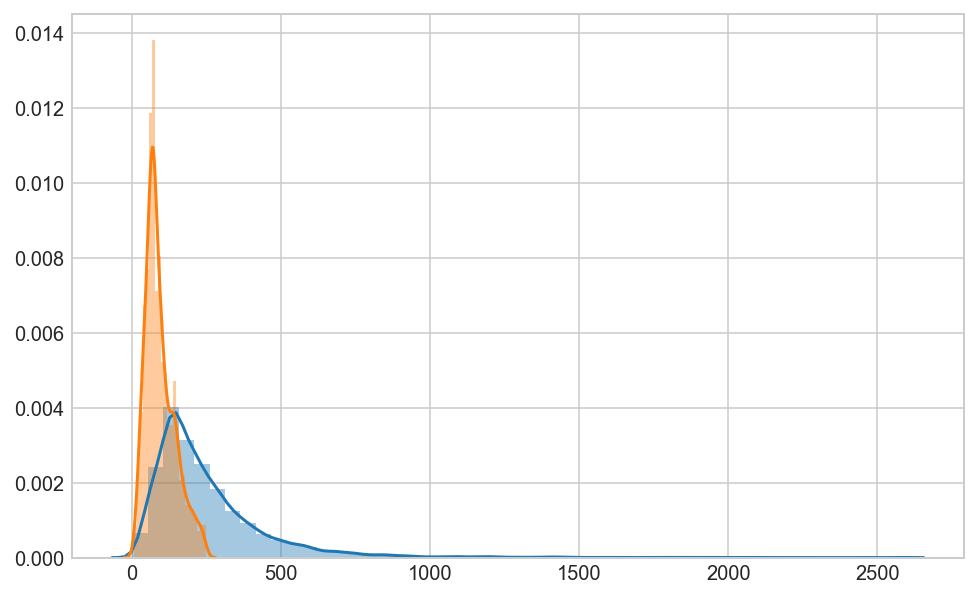

In [149]:
sns.distplot(MASTER_RFM_noweak.loc[MASTER_RFM_noweak.CUMUL_VALUE.notnull(), ["CUMUL_VALUE"]])
sns.distplot(Weak.loc[Weak.CUMUL_VALUE.notnull(), ["CUMUL_VALUE"]])
plt.show()

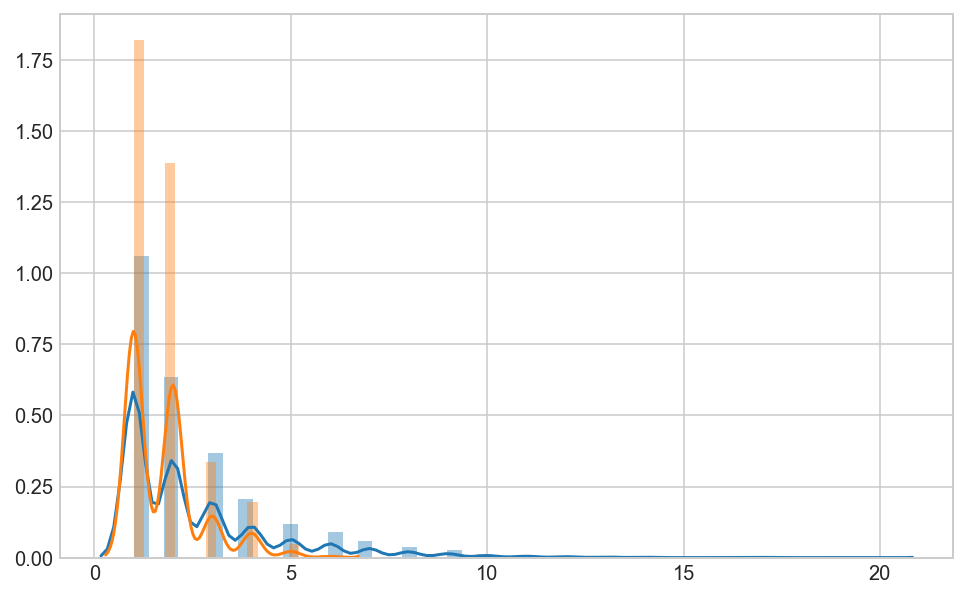

In [150]:
sns.distplot(MASTER_RFM_noweak.loc[MASTER_RFM_noweak.NB_GIFTS.notnull(), ["NB_GIFTS"]])
sns.distplot(Weak.loc[Weak.NB_GIFTS.notnull(), ["NB_GIFTS"]])
plt.show()

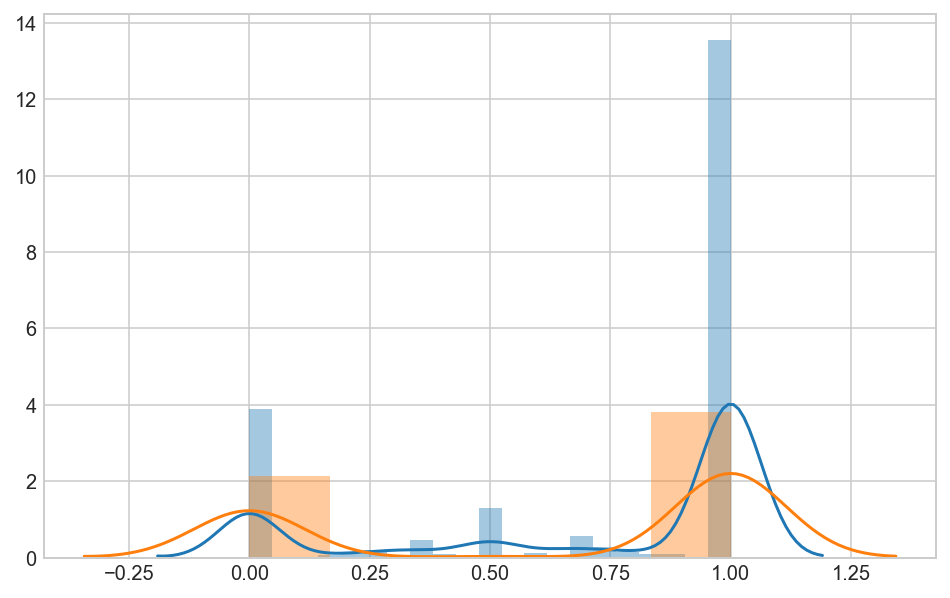

In [151]:
sns.distplot(MASTER_RFM_noweak.loc[MASTER_RFM_noweak.SHARE_MANAGING_STORE.notnull(), ["SHARE_MANAGING_STORE"]])
sns.distplot(Weak.loc[Weak.SHARE_MANAGING_STORE.notnull(), ["SHARE_MANAGING_STORE"]])
plt.show()

## 7. Migration across time

The aim here is to build a *matrice de passage* in order to :
* see the **migrations of customers** from one to another cluster
* evaluate the **change in size** of each cluster (are the clusters stable or not?)

We have to rerun the code beginning by the computation of the indicators of interest

In [152]:
min_date_RFM = '2015-06-01 00:00:00'
max_date_RFM = '2016-05-30 00:00:00'
RECEIPTS_INFO_RFM2 = RECEIPTS_INFO_OK[(RECEIPTS_INFO_OK.DATE_ACHAT >= min_date_RFM) & (RECEIPTS_INFO_OK.DATE_ACHAT <= max_date_RFM)]

In [153]:
RECEIPTS_INFO_RFM2.shape # more obs

(103729, 29)

**Compute the recency, frequency and monetary value criteria**

In [154]:
del VISIT_VALUE # erase the previous object to be sure no weird stuff will happen next

VISIT_VALUE = RECEIPTS_INFO_RFM2[
    ~RECEIPTS_INFO_RFM2.MODELE.isin(["FAVO","FAVORI","PLV"])].groupby(
    ["DATE_ACHAT", "CODE_BOUTIQUE", "ID_INDIVIDU", "NUM_TICKET"]).aggregate(
    {'PRICE': 'sum', 'QUANTITE': 'sum'}).reset_index()
# Here we remove all the lines of gifts and PVL, group by the smallest level of keys, and comp the total spendings and buyings
VISIT_VALUE.columns = ['DATE_ACHAT', 'CODE_BOUTIQUE',
                               'ID_INDIVIDU', 'NUM_TICKET', 
                               'VISIT_VALUE', 'NB_PRODUCTS']
# Visit value corresponds to the "panier total par visite d'un client à une date et un lieu précis"
VISIT_VALUE["AVG_PRICE"] = VISIT_VALUE["VISIT_VALUE"]/VISIT_VALUE["NB_PRODUCTS"]

In [155]:
del FREQUENCY

agg_dict = {"DATE_ACHAT": ["count"],
            "VISIT_VALUE": ["mean", 'sum'],
            'NB_PRODUCTS': ['mean']
           }

FREQUENCY = VISIT_VALUE.groupby('ID_INDIVIDU').aggregate(
    agg_dict, drop_index=True).reset_index()
FREQUENCY.columns = ['ID_INDIVIDU','NB_VISITS','AVG_VISIT_VALUE', 'CUMUL_VALUE','AVG_NB_PRODUCTS_VISIT']

In [156]:
del RECENCY

RECENCY = VISIT_VALUE.groupby('ID_INDIVIDU').aggregate(
    {'DATE_ACHAT': 'max'}).reset_index()
RECENCY["DATE_ACHAT"] = pd.to_datetime(RECENCY["DATE_ACHAT"])
max_date_RFM = pd.to_datetime(max_date_RFM)
RECENCY["RECENCY"] = (max_date_RFM - RECENCY["DATE_ACHAT"])/np.timedelta64(1, 'D')

**Other charactiristics of interest** (maybe not useful to keep here?)

In [157]:
del DIVERS_STORE
del DIVERS_LINE
del DIVERS_FAM

DIVERS_STORE = RECEIPTS_INFO_RFM2[(RECEIPTS_INFO_RFM2.MODELE != "PLV") 
                          & (RECEIPTS_INFO_RFM2.CODE_BOUTIQUE.notnull())].groupby('ID_INDIVIDU')["CODE_BOUTIQUE"].nunique().reset_index()
DIVERS_STORE.columns = ['ID_INDIVIDU', 'NB_STORES']

DIVERS_LINE = RECEIPTS_INFO_RFM2[(~RECEIPTS_INFO_RFM2.MODELE.isin(["FAVO","FAVORI","PLV"])) 
                          & (RECEIPTS_INFO_RFM2.Ligne.notnull())].groupby('ID_INDIVIDU')["Ligne"].nunique().reset_index()
DIVERS_LINE.columns = ['ID_INDIVIDU', 'NB_LINES']

DIVERS_FAM = RECEIPTS_INFO_RFM2[(~RECEIPTS_INFO_RFM2.MODELE.isin(["FAVO","FAVORI","PLV"])) 
                          & (RECEIPTS_INFO_RFM2.Famille.notnull())].groupby('ID_INDIVIDU')["Famille"].nunique().reset_index()
DIVERS_FAM.columns = ['ID_INDIVIDU', 'NB_FAMILIES']

In [158]:
del NB_GIFTS

NB_GIFTS = RECEIPTS_INFO_RFM2[(RECEIPTS_INFO_RFM2.MODELE.isin(["FAVO","FAVORI"])) 
                          | (RECEIPTS_INFO_RFM2.PRICE==0)].groupby('ID_INDIVIDU')["DATE_ACHAT"].count().reset_index()
NB_GIFTS.columns = ['ID_INDIVIDU', 'NB_GIFTS']
NB_GIFTS.head()

,ID_INDIVIDU,NB_GIFTS
0,99,1
1,557,11
2,1396,5
3,1579,3
4,2096,8


In [159]:
del MANAGING_STORE
del SHARE_MANAGING_STORE

MANAGING_STORE = VISIT_VALUE[["ID_INDIVIDU","CODE_BOUTIQUE"]].merge(CUSTOMERS_INFO_OK[["ID_INDIVIDU","MANAGING_STORE"]], on = ["ID_INDIVIDU"])
MANAGING_STORE["TOP_MANAGING_STORE"] = np.where(MANAGING_STORE.CODE_BOUTIQUE == MANAGING_STORE.MANAGING_STORE, 1, 0)

SHARE_MANAGING_STORE = MANAGING_STORE.groupby('ID_INDIVIDU')["TOP_MANAGING_STORE"].mean().reset_index()
SHARE_MANAGING_STORE.columns = ['ID_INDIVIDU', 'SHARE_MANAGING_STORE']

Computation of **age** and **seniority** with the new upper date boundary

Treatment of inconsistent **age** and conversion + treatment of **seniority** in months

In [160]:
CUSTOMERS_INFO_OK["AGE"] = round(((max_date_RFM - CUSTOMERS_INFO_OK.BIRTH_DATE)/np.timedelta64(1, 'Y')),0)
CUSTOMERS_INFO_OK["AGE"] = np.where((CUSTOMERS_INFO_OK.AGE < 15) | (CUSTOMERS_INFO_OK.AGE > 90), np.nan, CUSTOMERS_INFO_OK.AGE)

In [161]:
CUSTOMERS_INFO_OK["SENIORITY"] = (max_date_RFM - CUSTOMERS_INFO_OK.DATE_CREATION_CARTE)/np.timedelta64(1, 'M')

In [162]:
CUSTOMERS_INFO_OK["SENIORITY"] = np.where((CUSTOMERS_INFO_OK["SENIORITY"]>120), np.nan, CUSTOMERS_INFO_OK["SENIORITY"])

**Merges to execute to construct the big data set we will use to design the segmentation**

In [163]:
# This time keep previous MASTER 

MASTER2 = CUSTOMERS_INFO_OK[['ID_INDIVIDU','CIVILITE',
                            'SEXE','PROFESSION','CATEGORIE_PROF', # profession and categorie profession won't be so useful (NA)
                            'DATE_CREATION_CARTE','MANAGING_STORE',
                            'AGE','SENIORITY']].merge(SHARE_MANAGING_STORE,
                                                     on='ID_INDIVIDU',
                                                     how='left')

MASTER2 = MASTER2.merge(NB_GIFTS, on='ID_INDIVIDU', how='left')

MASTER2 = MASTER2.merge(DIVERS_STORE, on='ID_INDIVIDU', how='left')
MASTER2 = MASTER2.merge(DIVERS_LINE, on='ID_INDIVIDU', how='left')
MASTER2 = MASTER2.merge(DIVERS_FAM, on='ID_INDIVIDU', how='left')

MASTER2 = MASTER2.merge(RECENCY, on='ID_INDIVIDU', how='left')
MASTER2 = MASTER2.merge(FREQUENCY, on='ID_INDIVIDU', how='left')

len(MASTER2) # out of curiosity (normally 36 157 individuals)

36157

In [164]:
MASTER_RFM2 = MASTER2[MASTER2.RECENCY.notnull()]
len(MASTER_RFM2) # 1/3 of the MASTER2 table (2/3 of the base are inactives customers)

11667

In [165]:
MASTER_RFM2.loc[(MASTER_RFM2.CUMUL_VALUE <= 0.0),].shape # Only 61 customers concerned
MASTER_RFM2 = MASTER_RFM2.loc[(MASTER_RFM2.CUMUL_VALUE > 0.0),]
# Here, we are maybe introducing some difficulty as some customers will be erased of the base but present on the previous one, thus we won't be able to know their migration

**Create the segment of new customers**

In [166]:
MASTER_RFM2["TOP_NEW2"] = np.where((MASTER_RFM2.SENIORITY <= 12), 1, 0) # If TOP_NEW is used -> big warning

**RFM : thresholds and implementation**

As we want to compare with 2 different periods the evolution of groups, we have to take the exact same thresholds

In [167]:
MASTER_RFM2.loc[(MASTER_RFM2.TOP_NEW2==0),
                ['CUMUL_VALUE','NB_VISITS','RECENCY']].quantile([0.33,0.67])
# We can see that the criteria of the previous RFM won't be optimal applied here.

min_recency = 120
max_recency = 210
min_frequency = 1
max_frequency = 3
min_money = 100
max_money = 250

# Already defined, but to be sure..

In [168]:
MASTER_RFM2["RECENCY_level"] = np.where(MASTER_RFM2.TOP_NEW2 == 1, '4 - New',
                                      np.where(MASTER_RFM2.RECENCY > max_recency, '1 - Low',
                                              np.where(MASTER_RFM2.RECENCY <= min_recency, '3 - High',
                                                      '2 - Medium')))

MASTER_RFM2["FREQUENCY_level"] = np.where(MASTER_RFM2.TOP_NEW2 == 1, '4 - New',
                                        np.where(MASTER_RFM2.NB_VISITS <= min_frequency, '1 - Low',
                                                np.where(MASTER_RFM2.NB_VISITS >= max_frequency, '3 - High',
                                                        '2 - Medium')))

MASTER_RFM2["MONEY_level"] = np.where(MASTER_RFM2.TOP_NEW2 == 1, '4 - New',
                                    np.where(MASTER_RFM2.CUMUL_VALUE < min_money, '1 - Low',
                                            np.where(MASTER_RFM2.CUMUL_VALUE >= max_money, '3 - High',
                                                    '2 - Medium')))

In [169]:
cond_LowFM = ( ((MASTER_RFM2.FREQUENCY_level=='1 - Low') & ((MASTER_RFM2.MONEY_level=='1 - Low') | (MASTER_RFM2.MONEY_level=='2 - Medium'))) | ((MASTER_RFM2.FREQUENCY_level=='2 - Medium') & (MASTER_RFM2.MONEY_level=='1 - Low')) )

cond_MediumFM = ( ((MASTER_RFM2.FREQUENCY_level=='3 - High') & (MASTER_RFM2.MONEY_level=='1 - Low')) | ((MASTER_RFM2.FREQUENCY_level=='2 - Medium') & (MASTER_RFM2.MONEY_level=='2 - Medium')) | ((MASTER_RFM2.FREQUENCY_level=='1 - Low') & (MASTER_RFM2.MONEY_level=='3 - High')) )

cond_HighFM = ( ((MASTER_RFM2.MONEY_level=='3 - High') & ((MASTER_RFM2.FREQUENCY_level=='3 - High') | (MASTER_RFM2.FREQUENCY_level=='2 - Medium'))) | ((MASTER_RFM2.FREQUENCY_level=='3 - High') & (MASTER_RFM2.MONEY_level=='2 - Medium')) )

MASTER_RFM2["FM_SEG"] = np.where(MASTER_RFM2.TOP_NEW2, '4 - New',
                                 np.where(cond_LowFM, '1 - Low',
                                          np.where(cond_HighFM, '3 - High',
                                                   '2 - Medium')))

In [170]:
cond_Top = ( (MASTER_RFM2.RECENCY_level == "3 - High") & ((MASTER_RFM2.FM_SEG == "2 - Medium") | (MASTER_RFM2.FM_SEG == "3 - High")) )
cond_Good = ( (MASTER_RFM2.RECENCY_level == "2 - Medium") & ((MASTER_RFM2.FM_SEG == "2 - Medium") | (MASTER_RFM2.FM_SEG == "3 - High")) )
cond_Decel = ( (MASTER_RFM2.RECENCY_level == "1 - Low") & ((MASTER_RFM2.FM_SEG == "2 - Medium") | (MASTER_RFM2.FM_SEG == "3 - High")) )
cond_Small = ( (MASTER_RFM2.FM_SEG == "1 - Low") & ((MASTER_RFM2.RECENCY_level == "2 - Medium") | (MASTER_RFM2.RECENCY_level == "3 - High")) )
cond_Weak = ( (MASTER_RFM2.RECENCY_level == "1 - Low") & (MASTER_RFM2.FM_SEG == "1 - Low") )

In [171]:
MASTER_RFM2["RFM_SEG2"] = np.where(MASTER_RFM2.TOP_NEW2, '6 - New',
                                   np.where(cond_Top, '1 - Top customers',
                                            np.where(cond_Good, '2 - Good customers',
                                                     np.where(cond_Decel, '3 - Decelerations',
                                                              np.where(cond_Small, '4 - Small customers',
                                                                       '5 - Weak customers')))))

### Merge the 2 RFM and do a crosstab to see the repartition

First of all, we have to allocate the RFM segments in the MASTER table (the na will take the value "7 - Inactives").

Then, we'll merge MASTER and MASTER2, keeping only the segments variable on each and do a crosstab.

In [175]:
MASTER_RFM.RFM_SEG.unique()
MASTER_RFM.RFM_SEG.replace('Top', '1 - Top customers', inplace = True)
MASTER_RFM.RFM_SEG.replace('Good', '2 - Good customers', inplace = True)
MASTER_RFM.RFM_SEG.replace('Decel', '3 - Decelerations', inplace = True)
MASTER_RFM.RFM_SEG.replace('Small', '4 - Small customers', inplace = True)
MASTER_RFM.RFM_SEG.replace('Weak', '5 - Weak customers', inplace = True)
MASTER_RFM.RFM_SEG.replace('New', '6 - New', inplace = True)

In [177]:
MASTER = MASTER.merge(MASTER_RFM[["ID_INDIVIDU", "RFM_SEG"]], on = "ID_INDIVIDU", how = "left") # left because we want to keep the inactives
MASTER.RFM_SEG.fillna("7 - Inactives", axis = 0, inplace = True)
MASTER.head(4)

,ID_INDIVIDU,CIVILITE,SEXE,PROFESSION,CATEGORIE_PROF,DATE_CREATION_CARTE,MANAGING_STORE,AGE,SENIORITY,SHARE_MANAGING_STORE,NB_GIFTS,NB_STORES,NB_LINES,NB_FAMILIES,DATE_ACHAT,RECENCY,NB_VISITS,AVG_VISIT_VALUE,CUMUL_VALUE,AVG_NB_PRODUCTS_VISIT,RFM_SEG
0,4,0,0,NaN,NaN,1989-01-01,751,NaN,NaN,0.0,1.0,4.0,3.0,4.0,2016-07-23,130.0,6.0,79.166667,475.0,2.166667,2 - Good customers
1,27,3,2,NaN,3.0,2007-08-08,942,49.0,111.772316,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,7 - Inactives
2,34,3,2,NaN,6.0,2007-07-27,942,64.0,112.166574,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,7 - Inactives
3,37,2,2,NaN,3.0,2007-11-07,942,52.0,108.782521,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,7 - Inactives


In [178]:
MASTER.RFM_SEG.value_counts()

7 - Inactives          25456
6 - New                 3369
5 - Weak customers      1694
1 - Top customers       1683
2 - Good customers      1655
4 - Small customers     1601
3 - Decelerations        699
Name: RFM_SEG, dtype: int64

In [179]:
MASTER2 = MASTER2.merge(MASTER_RFM2[["ID_INDIVIDU", "RFM_SEG2"]], on = "ID_INDIVIDU", how = "left") # left because we want to keep the inactives
MASTER2.RFM_SEG2.fillna("7 - Inactives", axis = 0, inplace = True)
MASTER2.head(4)

,ID_INDIVIDU,CIVILITE,SEXE,PROFESSION,CATEGORIE_PROF,DATE_CREATION_CARTE,MANAGING_STORE,AGE,SENIORITY,SHARE_MANAGING_STORE,NB_GIFTS,NB_STORES,NB_LINES,NB_FAMILIES,DATE_ACHAT,RECENCY,NB_VISITS,AVG_VISIT_VALUE,CUMUL_VALUE,AVG_NB_PRODUCTS_VISIT,RFM_SEG2
0,4,0,0,NaN,NaN,1989-01-01,751,NaN,NaN,0.0,NaN,2.0,2.0,2.0,2016-02-07,113.0,2.0,72.0,144.0,1.0,1 - Top customers
1,27,3,2,NaN,3.0,2007-08-08,942,49.0,105.727017,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,7 - Inactives
2,34,3,2,NaN,6.0,2007-07-27,942,63.0,106.121276,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,7 - Inactives
3,37,2,2,NaN,3.0,2007-11-07,942,52.0,102.737223,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,7 - Inactives


In [180]:
MASTER2.RFM_SEG2.value_counts()

7 - Inactives          24551
6 - New                 4284
1 - Top customers       2874
4 - Small customers     1639
5 - Weak customers      1415
2 - Good customers       868
3 - Decelerations        526
Name: RFM_SEG2, dtype: int64

In [181]:
MIG = MASTER[["ID_INDIVIDU","RFM_SEG"]].merge(MASTER2[["ID_INDIVIDU","RFM_SEG2"]], on = "ID_INDIVIDU", how = "inner")
# Here, we use an inner join as ALL individuals are present on both tables

**Clusters evolution** with Inactives

In [182]:
pd.crosstab(MIG.RFM_SEG2, MIG.RFM_SEG, margins = True)

RFM_SEG,1 - Top customers,2 - Good customers,3 - Decelerations,4 - Small customers,5 - Weak customers,6 - New,7 - Inactives,All
RFM_SEG2,,,,,,,,
1 - Top customers,880,949,498,133,377,0,37,2874
2 - Good customers,174,157,98,72,230,0,137,868
3 - Decelerations,56,28,0,131,0,0,311,526
4 - Small customers,185,187,0,215,850,0,202,1639
5 - Weak customers,57,38,0,258,0,0,1062,1415
6 - New,245,246,103,200,237,2193,1060,4284
7 - Inactives,86,50,0,592,0,1176,22647,24551
All,1683,1655,699,1601,1694,3369,25456,36157
